In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import ticker as mticker

import plotly.express as px
import plotly.io as pio

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram, spectrogram

plt.style.use('seaborn-v0_8-whitegrid')
plt.rc("figure", autolayout=True, figsize=(10, 4))
plt.rc("axes", labelweight="bold", titleweight="bold")
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

pio.templates.default = "plotly_white"
px.defaults.width = 1200
px.defaults.height = 400

ETS models:

$$y(t) = g(t) + s(t) + \epsilon_t$$

Additive seasonality:

$$y(t) = g(t) + s(t)$$

Multiplicative seasonality:

$$y(t) = g(t) \cdot s(t)$$

AR(p) model:

$$y_t = b + \phi_1y_{t-1} + \phi_2y_{t-2} + ... + \phi_py_{t-p} + \epsilon_t$$

Fourier formula:

$$s(t) = \sum_{n=1}^{N}\left(a_{n}cos\left(\frac{2\pi nt}{P}\right) + b_{n}sin\left(\frac{2\pi nt}{P}\right)\right)$$

One-hot encoding:

$$s(t) = \sum_{p=1}^{P}\beta_{p}C_{p}$$

Dummy variables:

$$s(t) = \sum_{p=1}^{P-1}\beta_{p}C_{p}$$

In [2]:
def plot_periodogram(ts, detrend='linear', window='blackmanharris', scaling='density', ts_frequency=None, show_minor_ticks=True, axsize=(12, 3)):
    """
    Take timeseris and plot the periodogram(s).
    If data has multiple columns, one plot is made
    for each column.
    The time period format (df.index.to_period()) is
    preferred for clarity, but any format will work.

    Parameters
    ----------
    ts : DataFrame or Series with data to visualize
    detrend : whether and how to detrend the data
    window : the shape of the time window
    scaling : return either power spectral density
              or power spectrum
    ts_frequency : override timeseries index frequency
                   (for display only, in the xlabel)
    show_minor_ticks : plot minor ticks
    axsize : the size of a single plot in the figure

    Returns
    -------
    Nothing - just displays the figure.

    See scipy.signal.periodogram for more details.
    """

    if not isinstance(ts, pd.Series) and not isinstance(ts, pd.DataFrame):
        raise Exception(f'data must be pd.Series or pd.DataFrame')
    if isinstance(ts, pd.Series):
        ts = pd.DataFrame(ts)

    num_cols = len(ts.columns.to_list())
    fig, ax = plt.subplots(num_cols, 1, figsize=(axsize[0], num_cols * axsize[1]), layout='constrained')
    if num_cols == 1:
        ax = np.array([ax])
    for i in range(num_cols):
        c = ts.columns.to_list()[i]
        frequencies, spectrum = periodogram(
            ts[c],
            fs=1,
            detrend=detrend,
            window=window,
            scaling=scaling,
        )
        with np.errstate(divide='ignore'):
            periods = 1 / frequencies
        ax[i].step(periods, spectrum, color="purple")
        ax[i].set_xscale("log")
        ax[i].xaxis.set_major_formatter('{x:.0f}')
        if show_minor_ticks:
            ax[i].xaxis.set_minor_formatter('{x:.0f}')
            ax[i].grid(visible=True, which='both', axis='both')
        else:
            ax[i].grid(visible=True, which='major', axis='both')
        xlabel = f'period (number of observations)'
        if ts_frequency is not None:
            xlabel += f', freqstr: {ts_frequency}'
        else:
            if hasattr(ts.index, 'freqstr'):
                xlabel += f', freqstr: {ts.index.freqstr}'
        ax[i].set_xlabel(xlabel)
        if scaling == 'density':
            ax[i].set_ylabel("power density")
        else:
            ax[i].set_ylabel("power")
        ax[i].set_title(c)
    fig.suptitle('Periodogram')
    fig.show()


def compute_spectrum(ts_data, max_period, min_amplitude=0.01, detrend='linear'):
    """
    Take timeseries data and compute its Fourier spectrogram.
    E.g.:
    If the time period of the timeseries data is 1 day, then
        max_period=7 will extract components with periods <= 7 days.
    If the time period of the timeseries data is 1 quarter, then
        max_period=4 will look at periods <= 1 year.
    max_period cannot be greater than the length of the data.
    max_period/2 observations are lost at each end of the spectrogram.
    Periods are intervals within the timeseries index.

    Parameters
    ----------
    ts_data : pd.Series() containing the data to be analyzed,
              and its time index
    max_period : the largest period that will be extracted from
                 the signal, measured in number of observations
    min_amplitude : only return components with relative amplitudes
                    higher than this value; 0.0 means 'all'
    detrend : the scipy.signal.spectrogram() detrend argument.
              Options:
              - False
              - 'constant'
              - 'linear'
              - a function

    Returns
    -------
    spectrum : pd.DataFrame
               the index is a subset of the index of the original
                    timeseries data
               the columns are the amplitudes of the various
                    Fourier components
               the column names represent the component periods

    To be useful, each component should be smoothed with
        a time window larger than its period (about 4x).
    """

    nperseg = max_period
    noverlap = nperseg - 1

    frequencies, times, spectrum = spectrogram(x=ts_data, nperseg=nperseg, noverlap=noverlap, detrend=detrend)
    times = pd.DataFrame({'time_index': times}).round().astype(int)
    with np.errstate(divide='ignore'):
        periods = pd.DataFrame({'period': 1 / frequencies}).round(decimals=3).astype(str)
    spectrum = pd.DataFrame(spectrum.T, columns=periods['period'].to_list(), index=ts_data.index[times['time_index']])
    relative_amplitudes = spectrum.sum(axis=0) / spectrum.sum(axis=0).max()
    spectrum = spectrum[relative_amplitudes[relative_amplitudes >= min_amplitude].index.to_list()]
    return spectrum


def plot_spectrogram(spectrum, smoothing_window=4, log_amplitude=False, figsize_x=12, figsize_y=None):
    """
    Take a pd.DataFrame() with a signal spectrum,
    and plot its spectrogram.
    Also plot the variation in time of the envelope
    (average value, or amplitude) of each spectral component.

    Parameters
    ----------
    spectrum : pd.DataFrame() with the signal spectrum.
               The index is a subset of the timeseries index.
               Columns are named after the period of
                    each component.
    smoothing_window : Smooth the data with a multiple of the
                       greatest period. Default is 4. Reduce it
                       if max_period is a large fraction of
                       the dataset length, or else the plot
                       will be inaccurate at the edges.
    log_amplitude : Plot envelopes on a log scale.
    figsize_x : Horizontal size of the plot.
    figsize_y : Default None. The vertical size is computed,
                    depending on the number of components.
                If not None, the size is forced to this value.

    Returns
    -------
    No return, it just plots the spectrogram.
    """
    if figsize_y == None:
        figsize_y = min(max(2 * len(spectrum.columns.to_list()), 6), 40)
    periods = [p for p in spectrum.columns.astype(float).to_list() if p not in [np.inf]]
    max_period = max(periods)

    fig, ax = plt.subplots(2, 1, figsize=(figsize_x, figsize_y))

    ax[0].pcolormesh(spectrum.index.astype(str).to_list(), spectrum.columns.to_list(), spectrum.T, cmap='viridis', shading='auto')
    ax[0].xaxis.set_major_locator(mticker.MaxNLocator(nbins=round(figsize_x), min_n_ticks=2))
    ax[0].tick_params(axis='x', labelrotation=45)
    ax[0].grid(visible=True, which='both', axis='both')
    ax[0].set_ylabel('period')
    ax[0].set_xlabel('time index')
    ax[0].set_title('spectrogram')

    ax[1].set_ylabel('amplitude')
    ax[1].set_xlabel('time index')
    ax[1].set_title(f'component envelopes, smoothed {smoothing_window}x')
    spectrum = spectrum.rolling(window=round(smoothing_window * max_period), min_periods=1, center=True, win_type='blackmanharris').sum()
    spectrum.plot(ax=ax[1], logy=log_amplitude)
    ax[1].grid(visible=True, which='both', axis='both')
    ax[1].legend(title='components')

    fig.suptitle('Fourier visualization')
    fig.set_layout_engine(layout='tight')
    fig.show()

https://www.key2stats.com/data-set/view/776

In [3]:
df = pd.read_csv('Quarterly_Australian_Portland_Cement_production_776_10.csv', usecols=['time', 'value'])
# convert time from year float to a proper datetime format
df['time'] = df['time'].apply(lambda x: str(int(x)) + '-' + str(int(1 + 12 * (x % 1))).rjust(2, '0'))
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time').to_period()
df.rename(columns={'value': 'production'}, inplace=True)
print(df)

        production
time              
1956Q1       0.465
1956Q2       0.532
1956Q3       0.561
1956Q4       0.570
1957Q1       0.529
...            ...
2013Q1       2.049
2013Q2       2.528
2013Q3       2.637
2013Q4       2.565
2014Q1       2.229

[233 rows x 1 columns]


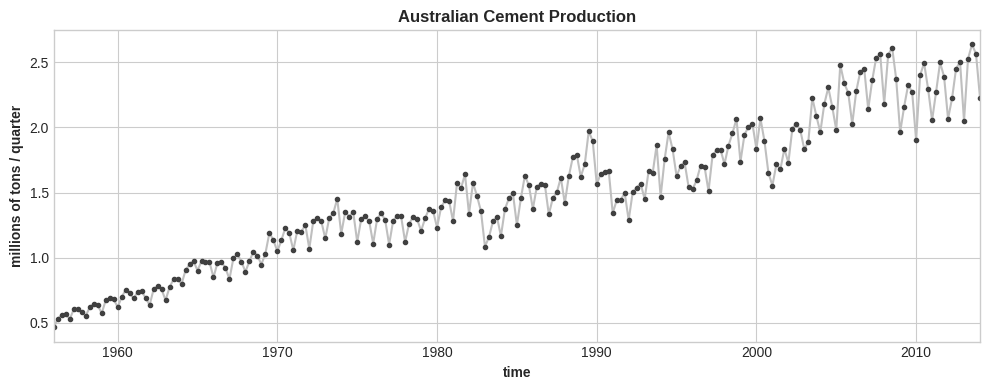

In [4]:
ax = df.plot(**plot_params)
ax.set_title('Australian Cement Production')
ax.set_xlabel('time')
_ = ax.set_ylabel('millions of tons / quarter')

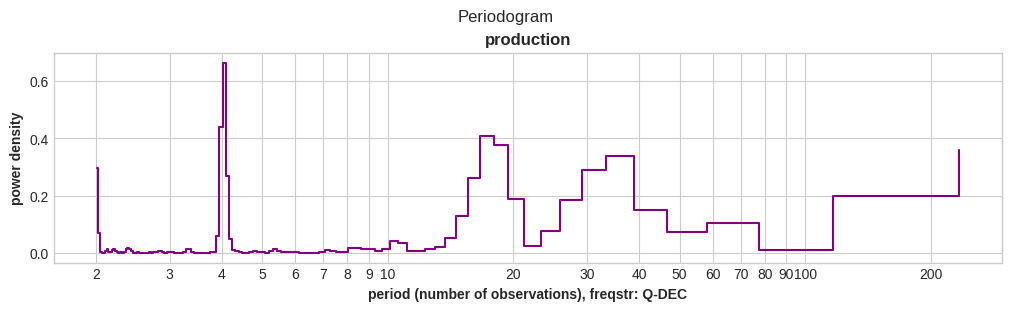

In [5]:
_ = plot_periodogram(df['production'], axsize=(10, 3))

period is measured in quarters


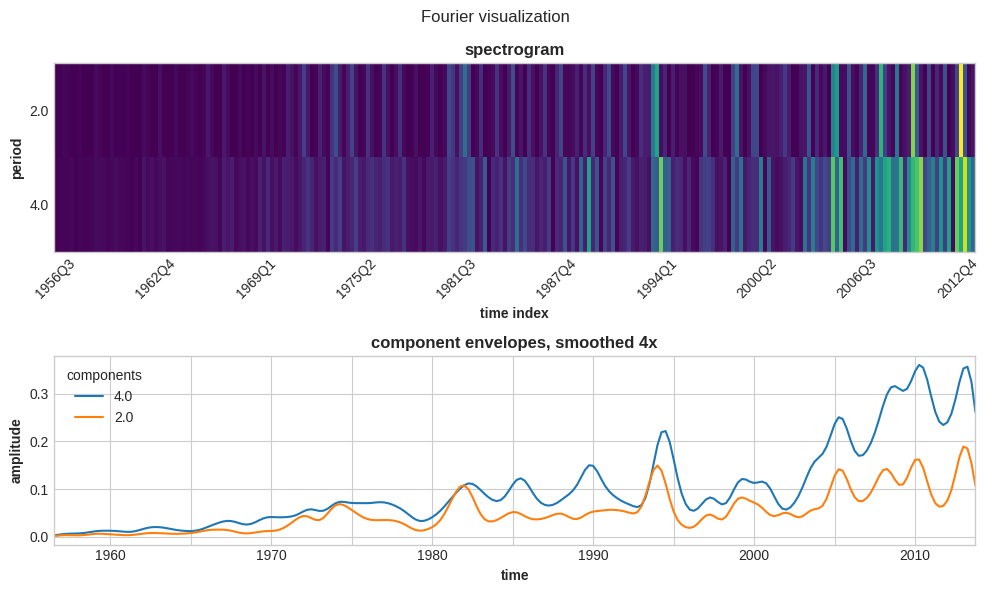

In [6]:
print('period is measured in quarters')
spectrum = compute_spectrum(df['production'], 4, 0.1)
plot_spectrogram(spectrum, figsize_x=10)

In [7]:
df.index

PeriodIndex(['1956Q1', '1956Q2', '1956Q3', '1956Q4', '1957Q1', '1957Q2',
             '1957Q3', '1957Q4', '1958Q1', '1958Q2',
             ...
             '2011Q4', '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1',
             '2013Q2', '2013Q3', '2013Q4', '2014Q1'],
            dtype='period[Q-DEC]', name='time', length=233)

In [8]:
trend_order = 2
trend_year = DeterministicProcess(index=df.index, constant=True, order=trend_order).in_sample()
trend_year

,const,trend,trend_squared
time,,,
1956Q1,1.0,1.0,1.0
1956Q2,1.0,2.0,4.0
1956Q3,1.0,3.0,9.0
1956Q4,1.0,4.0,16.0
1957Q1,1.0,5.0,25.0
...,...,...,...
2013Q1,1.0,229.0,52441.0
2013Q2,1.0,230.0,52900.0
2013Q3,1.0,231.0,53361.0


In [9]:
seasonal_year = DeterministicProcess(index=df.index, constant=False, seasonal=True, drop=True).in_sample()
seasonal_year

,"s(1,4)","s(2,4)","s(3,4)","s(4,4)"
time,,,,
1956Q1,1.0,0.0,0.0,0.0
1956Q2,0.0,1.0,0.0,0.0
1956Q3,0.0,0.0,1.0,0.0
1956Q4,0.0,0.0,0.0,1.0
1957Q1,1.0,0.0,0.0,0.0
...,...,...,...,...
2013Q1,1.0,0.0,0.0,0.0
2013Q2,0.0,1.0,0.0,0.0
2013Q3,0.0,0.0,1.0,0.0


In [10]:
cfr = CalendarFourier(freq='Y', order=2)
seasonal_year_trig = DeterministicProcess(index=df.index, seasonal=False, additional_terms=[cfr]).in_sample()
#with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False):
seasonal_year_trig

,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
time,,,,
1956Q1,0.000000,1.000000,0.000000,1.000000
1956Q2,0.999963,0.008583,0.017166,-0.999853
1956Q3,0.017166,-0.999853,-0.034328,0.999411
1956Q4,-0.999963,-0.008583,0.017166,-0.999853
1957Q1,0.000000,1.000000,0.000000,1.000000
...,...,...,...,...
2013Q1,0.000000,1.000000,0.000000,1.000000
2013Q2,0.999769,0.021516,0.043022,-0.999074
2013Q3,0.025818,-0.999667,-0.051620,0.998667


In [11]:
X = trend_year.copy()
X = X.join(seasonal_year)
print(X)

        const  trend  trend_squared  s(1,4)  s(2,4)  s(3,4)  s(4,4)
time                                                               
1956Q1    1.0    1.0            1.0     1.0     0.0     0.0     0.0
1956Q2    1.0    2.0            4.0     0.0     1.0     0.0     0.0
1956Q3    1.0    3.0            9.0     0.0     0.0     1.0     0.0
1956Q4    1.0    4.0           16.0     0.0     0.0     0.0     1.0
1957Q1    1.0    5.0           25.0     1.0     0.0     0.0     0.0
...       ...    ...            ...     ...     ...     ...     ...
2013Q1    1.0  229.0        52441.0     1.0     0.0     0.0     0.0
2013Q2    1.0  230.0        52900.0     0.0     1.0     0.0     0.0
2013Q3    1.0  231.0        53361.0     0.0     0.0     1.0     0.0
2013Q4    1.0  232.0        53824.0     0.0     0.0     0.0     1.0
2014Q1    1.0  233.0        54289.0     1.0     0.0     0.0     0.0

[233 rows x 7 columns]


In [12]:
last_date_train = '2009Q4'
first_date_test = '2010Q1'

index_train = X.loc[: pd.Period(last_date_train), :].index
index_test = X.loc[pd.Period(first_date_test) :, :].index

RMSLE: 0.03846449744356434


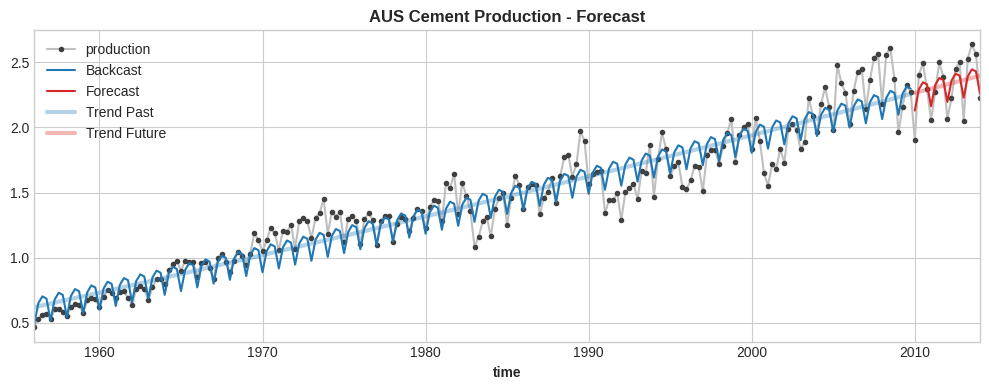

In [13]:
def do_forecast(X, index_train, index_test, trend_order):
    X_train = X.loc[index_train]
    X_test = X.loc[index_test]

    y_train = df['production'].loc[index_train]
    y_test = df['production'].loc[index_test]

    model = LinearRegression(fit_intercept=False)
    _ = model.fit(X_train, y_train)
    y_fore = pd.Series(model.predict(X_test), index=index_test)
    y_past = pd.Series(model.predict(X_train), index=index_train)

    trend_columns = X_train.columns.to_list()[0 : trend_order + 1]
    model_trend = LinearRegression(fit_intercept=False)
    _ = model_trend.fit(X_train[trend_columns], y_train)
    y_trend_fore = pd.Series(model_trend.predict(X_test[trend_columns]), index=index_test)
    y_trend_past = pd.Series(model_trend.predict(X_train[trend_columns]), index=index_train)

    RMSLE = mean_squared_log_error(y_test, y_fore, squared=False)
    print(f'RMSLE: {RMSLE}')

    ax = df.plot(**plot_params, title='AUS Cement Production - Forecast')
    ax = y_past.plot(color='C0', label='Backcast')
    ax = y_fore.plot(color='C3', label='Forecast')
    ax = y_trend_past.plot(ax=ax, color='C0', linewidth=3, alpha=0.333, label='Trend Past')
    ax = y_trend_fore.plot(ax=ax, color='C3', linewidth=3, alpha=0.333, label='Trend Future')
    _ = ax.legend()


do_forecast(X, index_train, index_test, trend_order)

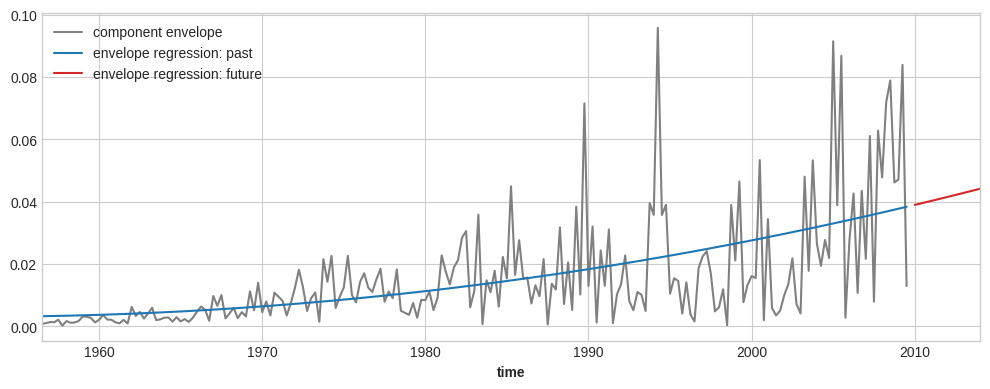

In [14]:
envelope_features = DeterministicProcess(index=X.index, constant=True, order=2).in_sample()

spec4_train = compute_spectrum(df['production'].loc[index_train], max_period=4)
spec4_train

spec4_model = LinearRegression()
spec4_model.fit(envelope_features.loc[spec4_train.index], spec4_train['4.0'])
spec4_regress = pd.Series(spec4_model.predict(envelope_features), index=X.index)

ax = spec4_train['4.0'].plot(label='component envelope', color='gray')
spec4_regress.loc[spec4_train.index].plot(ax=ax, color='C0', label='envelope regression: past')
spec4_regress.loc[index_test].plot(ax=ax, color='C3', label='envelope regression: future')
_ = ax.legend()

In [15]:
spec4_regress = spec4_regress / spec4_regress.mean()

season_columns = ['s(1,4)', 's(2,4)', 's(3,4)', 's(4,4)']
for c in season_columns:
    X[c] = X[c] * spec4_regress
print(X)

        const  trend  trend_squared    s(1,4)    s(2,4)    s(3,4)    s(4,4)
time                                                                       
1956Q1    1.0    1.0            1.0  0.179989  0.000000  0.000000  0.000000
1956Q2    1.0    2.0            4.0  0.000000  0.181109  0.000000  0.000000
1956Q3    1.0    3.0            9.0  0.000000  0.000000  0.182306  0.000000
1956Q4    1.0    4.0           16.0  0.000000  0.000000  0.000000  0.183581
1957Q1    1.0    5.0           25.0  0.184932  0.000000  0.000000  0.000000
...       ...    ...            ...       ...       ...       ...       ...
2013Q1    1.0  229.0        52441.0  2.434701  0.000000  0.000000  0.000000
2013Q2    1.0  230.0        52900.0  0.000000  2.453436  0.000000  0.000000
2013Q3    1.0  231.0        53361.0  0.000000  0.000000  2.472249  0.000000
2013Q4    1.0  232.0        53824.0  0.000000  0.000000  0.000000  2.491139
2014Q1    1.0  233.0        54289.0  2.510106  0.000000  0.000000  0.000000

[233 rows x

RMSLE: 0.02546321729737165


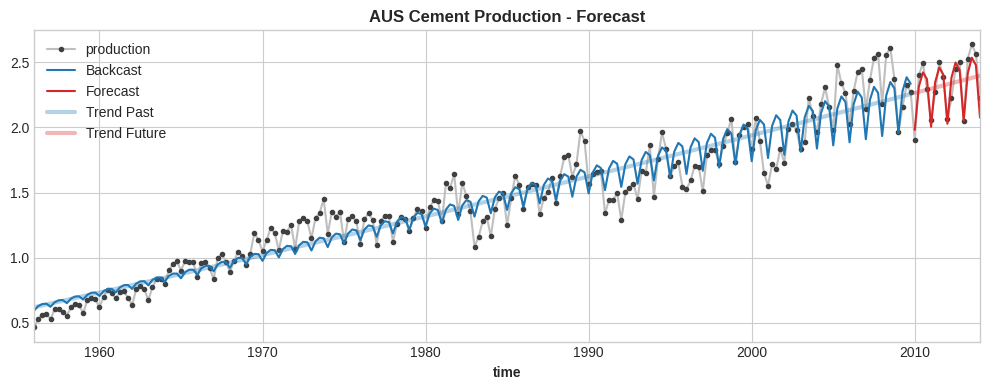

In [16]:
do_forecast(X, index_train, index_test, trend_order)